# Convolutional Neural Network Modeling and Evaluation + Transfer Learning Comparison
*Run on Google Colaboratory VM*

#Colab env reqs

In [1]:
#Getting nb to run: Run this cell, then restart runtime
#https://stackoverflow.com/questions/71000120/colab-0-unimplemented-dnn-library-is-not-found
!pip install tensorflow==2.10
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


# Imports, Updates, etc.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as ipd

from glob import glob
from PIL import Image

import librosa as lr
from librosa.display import waveplot, specshow
from librosa.core.spectrum import amplitude_to_db
from librosa.feature import melspectrogram

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, applications
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory, split_dataset

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


# Classical Metrics for Comparison

In [4]:
classical_ML_mets = pd.read_csv('/content/drive/MyDrive/Springboard/Classical_ML_Metrics.csv', index_col='Unnamed: 0')
classical_ML_mets

,accuracy,cv best f1,test macro avg f1,Train AUC,Test AUC
KNearestNeighbors,0.615,0.603849,0.608323,0.965472,0.912458
LogisticRegression,0.700,0.685577,0.691909,0.979939,0.949750
SVM,0.705,0.710727,0.698152,0.999988,0.956889
XGBoost,0.725,0.686891,0.719013,1.000000,0.951889
GradientBoostingClassifier,0.700,0.687605,0.690294,1.000000,0.951528


# Load and Check Melspectrograms
(and generate replacement melspec for Jazz song 54)

In [5]:
melspec_folder = '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

In [6]:
!ls '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms'

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [7]:
blues_pngs = glob(melspec_folder + '/blues/*.png')
classical_pngs = glob(melspec_folder + '/classical/*.png')
country_pngs = glob(melspec_folder + '/country/*.png')
disco_pngs = glob(melspec_folder + '/disco/*.png')
hiphop_pngs = glob(melspec_folder + '/hiphop/*.png')
jazz_pngs = glob(melspec_folder + '/jazz/*.png')
metal_pngs = glob(melspec_folder + '/metal/*.png')
pop_pngs = glob(melspec_folder + '/pop/*.png')
reggae_pngs = glob(melspec_folder + '/reggae/*.png')
rock_pngs = glob(melspec_folder + '/rock/*.png')

In [8]:
blues_pngs[:3]

['/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00031.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00033.png',
 '/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/blues/blues00028.png']

In [9]:
print(len(jazz_pngs))

100


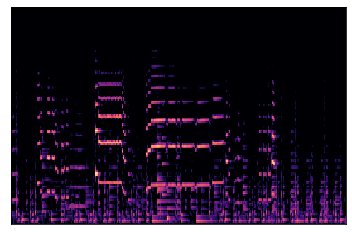

In [10]:
y, sr = lr.load('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSamples/jazz/jazz.00054.wav') # Replacement melspec for corrupted Jazz song (no. 54)
time = np.arange(0, len(y)) / sr
y_melspec = melspectrogram(y, sr=sr)
melspec_db = amplitude_to_db(np.abs(y_melspec))
jazz_melspec = specshow(melspec_db, sr=sr, cmap='magma');
# plt.savefig('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

Making sure the replacement melspectrogram resembles the others...

In [11]:
im = Image.open('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')
print(im.format, im.size, im.mode)

PNG (432, 288) RGBA


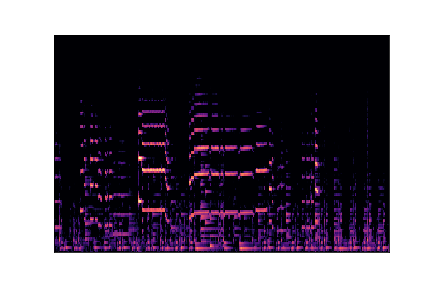

In [12]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00054.png')

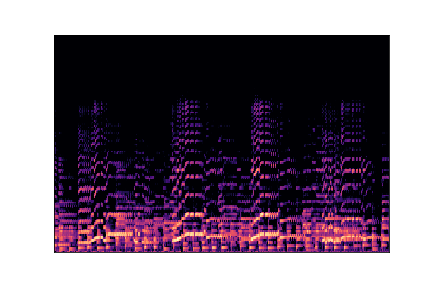

In [13]:
ipd.Image('/content/drive/MyDrive/Springboard/FinalCapstone_LabeledSongSpectrograms/jazz/jazz00055.png')

# Split into training, validation, and test datasets

In [14]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
# https://github.com/keras-team/keras/issues/15985#issuecomment-1165831985

train_ds, test_ds = image_dataset_from_directory(melspec_folder,
                                             labels='inferred',
                                             label_mode = 'int',
                                             color_mode = 'rgb',
                                             image_size = (432, 288),
                                             validation_split = 0.1,
                                             subset = 'both',
                                             seed = 42)

Found 1000 files belonging to 10 classes.
Using 900 files for training.
Using 100 files for validation.


In [15]:
# For future 'translation'
genre_dict = {0 : 'blues', 1 : 'classical', 2 : 'country', 3 : 'disco', 4 : 'hiphop', 5 : 'jazz', 6 : 'metal', 7 : 'pop', 8 : 'reggae', 9 : 'rock'}

In [16]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [17]:
tr_ds, val_ds = split_dataset(train_ds, left_size=0.85, right_size=0.15, shuffle=True, seed=42)

In [18]:
# Optimize for speed, utils.split_dataset() converts to PrefetchDataset, so only needed for unsplit test_ds
AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
print(len(train_ds), len(test_ds), test_ds)
print(len(tr_ds), len(val_ds), val_ds)

29 4 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
24 5 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 432, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 432, 288, 3)
(32,)


Quick view of the melspecs:

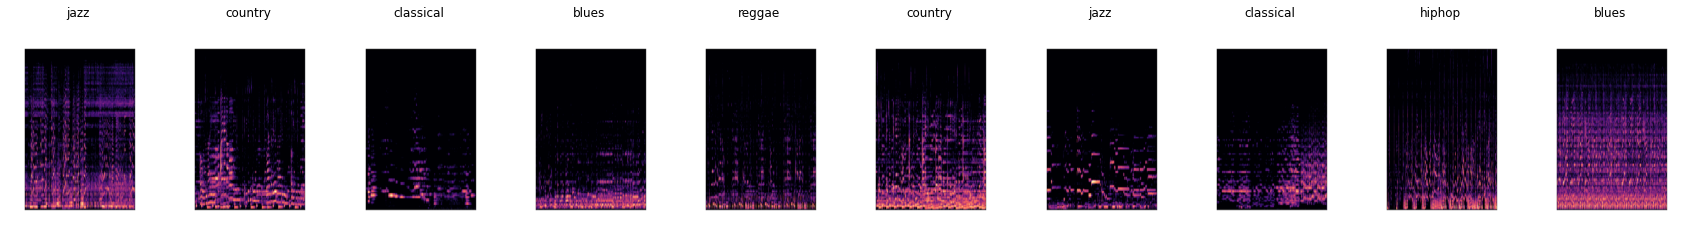

In [21]:
# https://www.tensorflow.org/tutorials/load_data/images

plt.figure(figsize=(30, 50))

for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Building our custom CNN

In [22]:
#https://www.tensorflow.org/tutorials/images/classification
batch_size, img_height, img_width, channels = (32, 432, 288, 3)

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, channels)))
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), strides=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2, seed=42))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.1, seed=42))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0002) , loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 432, 288, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 432, 288, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 216, 144, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 216, 144, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 144, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 108, 72, 32)      0         
 2D)                                                    

#Train & Evaluate Custom CNN

In [23]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.0001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=5e-6, )

In [24]:
hist = model.fit(tr_ds, validation_data=val_ds, epochs=150, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/150
24/24 [==============================] - 7s 100ms/step - loss: 14.8504 - accuracy: 0.1098 - val_loss: 11.5681 - val_accuracy: 0.0815 - lr: 2.0000e-04
Epoch 2/150
24/24 [==============================] - 1s 61ms/step - loss: 9.7794 - accuracy: 0.1150 - val_loss: 8.3154 - val_accuracy: 0.1111 - lr: 2.0000e-04
Epoch 3/150
24/24 [==============================] - 1s 61ms/step - loss: 7.5242 - accuracy: 0.1621 - val_loss: 6.8781 - val_accuracy: 0.1407 - lr: 2.0000e-04
Epoch 4/150
24/24 [==============================] - 1s 61ms/step - loss: 6.4529 - accuracy: 0.2183 - val_loss: 6.1760 - val_accuracy: 0.1481 - lr: 2.0000e-04
Epoch 5/150
24/24 [==============================] - 1s 61ms/step - loss: 5.8672 - accuracy: 0.2196 - val_loss: 5.7274 - val_accuracy: 0.1630 - lr: 2.0000e-04
Epoch 6/150
24/24 [==============================] - 1s 60ms/step - loss: 5.4654 - accuracy: 0.2314 - val_loss: 5.3173 - val_accuracy: 0.1852 - lr: 2.0000e-04
Epoch 7/150
24/24 [========================

In [25]:
score = model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 2.1901960372924805 and val_acc = 0.6700000166893005


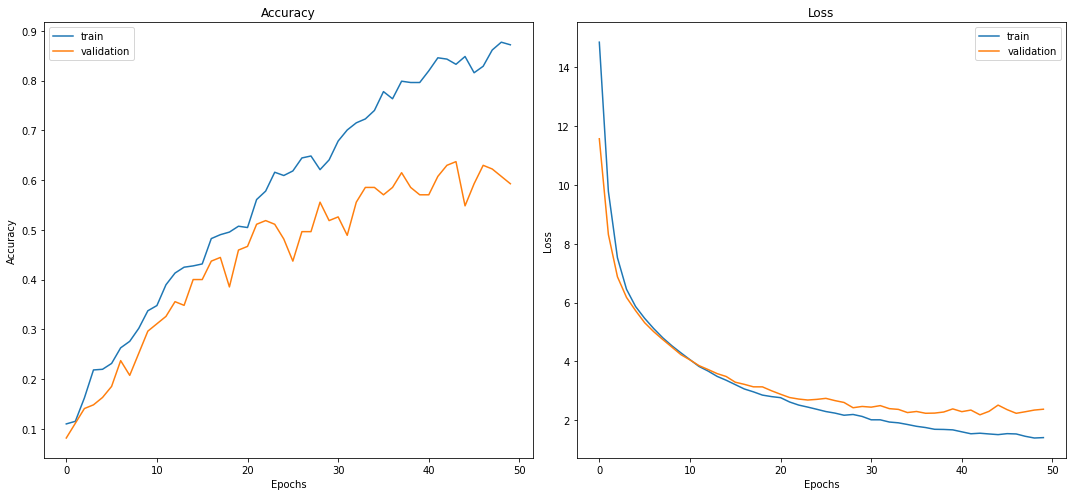

In [26]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
model.save('/content/drive/MyDrive/Springboard/SavedModel/custom_cnn.h5')

In [28]:
y_true = []

for i, j in list(test_ds.take(-1)):
  for arr in j:
    y_true.append(arr.numpy())

print(len(y_true), type(y_true[0]))

100 <class 'numpy.int32'>


In [29]:
y_true_str = [genre_dict[i] for i in y_true]

print(len(y_true_str), type(y_true_str[0]))

100 <class 'str'>


In [30]:
y_pred_arrs = model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

print(len(y_pred), type(y_pred[0]))

100 <class 'numpy.int64'>


In [31]:
y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

100 <class 'str'>


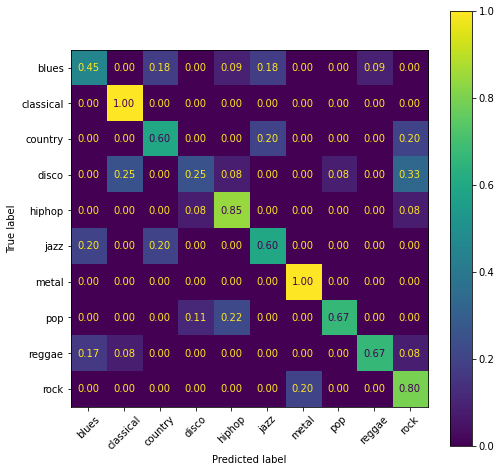

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

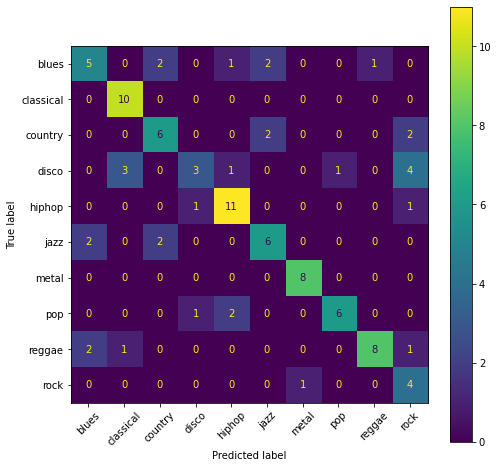

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [34]:
customCNN_metrics = {
    'Custom_CNN': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                   np.nan,
                   classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                   np.nan,
                   np.nan]
    }

#Transfer Learning Evaluation:
ResNet50, Mobile Net, VGG16

#ResNet50:

In [35]:
ResNet_inner = tf.keras.applications.ResNet50(weights='imagenet',
                                              input_shape=(img_height, img_width, channels),
                                              include_top=False)

ResNet_inner.trainable = False

input_ = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.applications.resnet50.preprocess_input(input_)
x = ResNet_inner(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_ = tf.keras.layers.Dense(10, activation='softmax')(x)
ResNet_model = tf.keras.Model(input_, output_)

ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

print(len(ResNet_model.trainable_variables), len(ResNet_model.layers))

ResNet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
2 6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 432, 288, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 432, 288, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 14, 9, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                          

In [36]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = ResNet_model.fit(tr_ds, validation_data=val_ds, epochs=80, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/80
24/24 [==============================] - 10s 247ms/step - loss: 2.6473 - accuracy: 0.0993 - val_loss: 2.3331 - val_accuracy: 0.1111 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 4s 159ms/step - loss: 2.2442 - accuracy: 0.1320 - val_loss: 2.2084 - val_accuracy: 0.1630 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 4s 159ms/step - loss: 2.1165 - accuracy: 0.2261 - val_loss: 2.0933 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 4/80
24/24 [==============================] - 4s 159ms/step - loss: 2.0091 - accuracy: 0.2954 - val_loss: 2.0019 - val_accuracy: 0.2370 - lr: 1.0000e-04
Epoch 5/80
24/24 [==============================] - 4s 158ms/step - loss: 1.9175 - accuracy: 0.3333 - val_loss: 1.9249 - val_accuracy: 0.2889 - lr: 1.0000e-04
Epoch 6/80
24/24 [==============================] - 4s 159ms/step - loss: 1.8388 - accuracy: 0.3908 - val_loss: 1.8585 - val_accuracy: 0.3630 - lr: 1.0000e-04
Epoch 7/80
24/24 [===========================

In [37]:
score = ResNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 0.9800246953964233 and val_acc = 0.7099999785423279


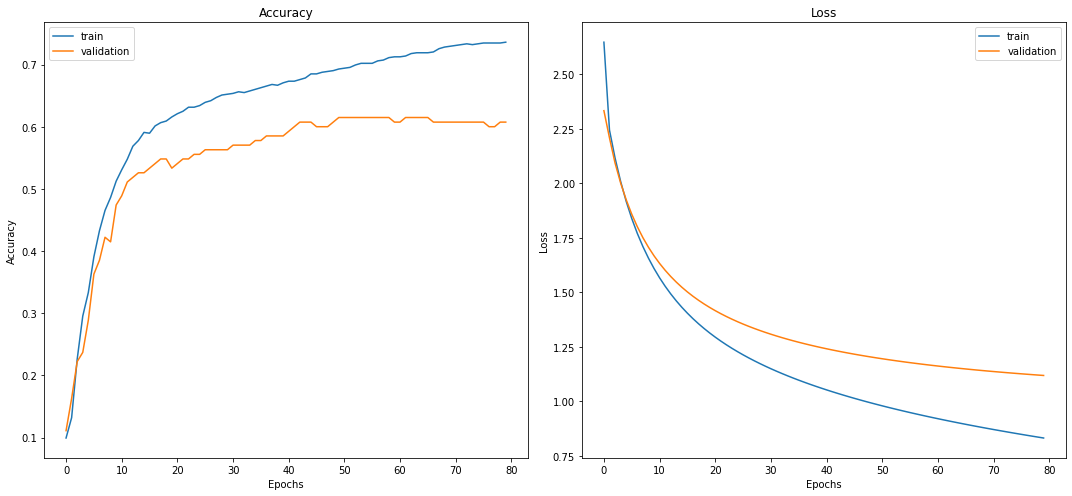

In [38]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##ResNet Fine-Tuning & Evaluation

In [39]:
ResNet_inner.trainable = True

ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

print(len(ResNet_inner.trainable_variables), len(ResNet_inner.layers))

ResNet_model.summary()

212 175
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 432, 288, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 432, 288, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 14, 9, 2048)       23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 10)              

In [40]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = ResNet_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 80/90
24/24 [==============================] - 20s 533ms/step - loss: 2.5920 - accuracy: 0.3072 - val_loss: 1.7722 - val_accuracy: 0.3704
Epoch 81/90
24/24 [==============================] - 11s 441ms/step - loss: 1.4100 - accuracy: 0.4797 - val_loss: 1.2508 - val_accuracy: 0.5704
Epoch 82/90
24/24 [==============================] - 11s 441ms/step - loss: 1.0451 - accuracy: 0.6248 - val_loss: 1.1258 - val_accuracy: 0.6519
Epoch 83/90
24/24 [==============================] - 11s 441ms/step - loss: 0.8358 - accuracy: 0.6980 - val_loss: 1.1963 - val_accuracy: 0.6148
Epoch 84/90
24/24 [==============================] - 11s 441ms/step - loss: 0.8410 - accuracy: 0.7098 - val_loss: 1.1726 - val_accuracy: 0.5926
Epoch 85/90
24/24 [==============================] - 11s 440ms/step - loss: 0.7001 - accuracy: 0.7556 - val_loss: 1.3493 - val_accuracy: 0.6074
Epoch 86/90
24/24 [==============================] - 11s 440ms/step - loss: 0.5250 - accuracy: 0.8157 - val_loss: 1.1738 - val_accuracy:

In [41]:
score = ResNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 1.2775297164916992 and val_acc = 0.6200000047683716


In [42]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

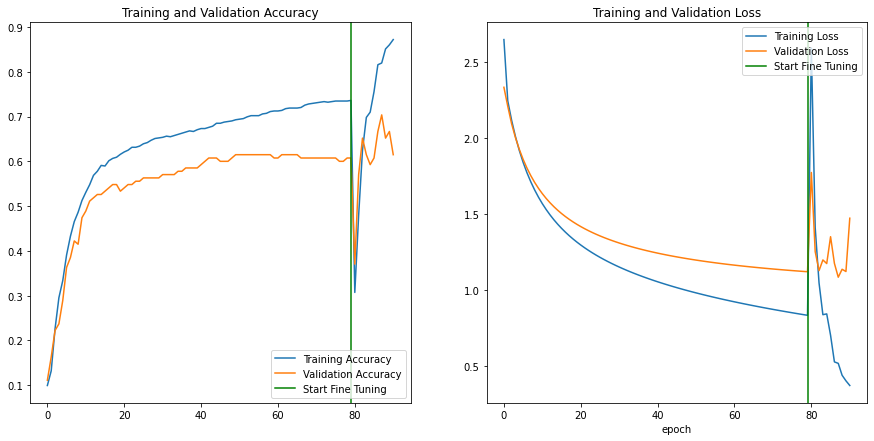

In [43]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [44]:
y_pred_arrs = ResNet_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

100 <class 'str'>


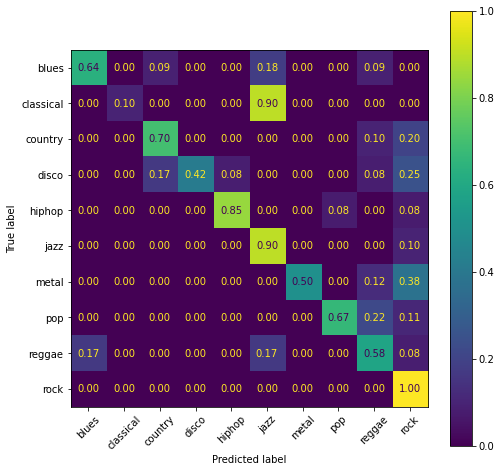

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

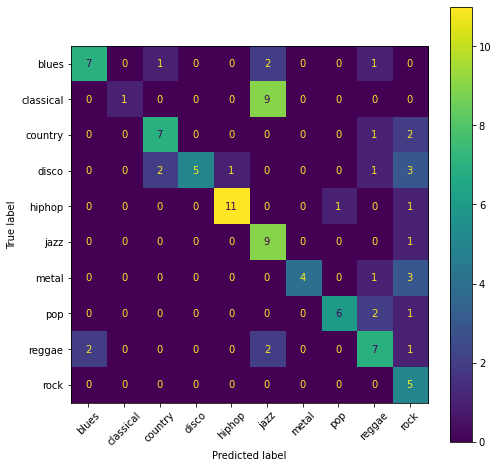

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [47]:
ResNet_metrics = {
    'ResNet50': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                 np.nan,
                 classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                 np.nan,
                 np.nan]
    }

#MobileNetV2:



In [48]:
MobileNet_inner = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3),
                                                                 include_top=False,
                                                                 weights='imagenet'
                                                                 )

MobileNet_inner.trainable = False
print(len(MobileNet_inner.trainable_variables), len(MobileNet_inner.layers))

9406464/9406464 [==============================] - 0s 0us/step
0 154


In [49]:
inputs = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = MobileNet_inner(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
MobileNet_model = tf.keras.Model(inputs, outputs)

MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

MobileNet_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [50]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = MobileNet_model.fit(tr_ds, validation_data=val_ds, epochs=80, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/80
24/24 [==============================] - 6s 109ms/step - loss: 2.7382 - accuracy: 0.0902 - val_loss: 2.3967 - val_accuracy: 0.1259 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 1s 51ms/step - loss: 2.4714 - accuracy: 0.1268 - val_loss: 2.2609 - val_accuracy: 0.1778 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 1s 52ms/step - loss: 2.3584 - accuracy: 0.1608 - val_loss: 2.1622 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 4/80
24/24 [==============================] - 1s 52ms/step - loss: 2.2121 - accuracy: 0.1987 - val_loss: 2.0688 - val_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 5/80
24/24 [==============================] - 1s 52ms/step - loss: 2.1391 - accuracy: 0.2261 - val_loss: 1.9884 - val_accuracy: 0.3407 - lr: 1.0000e-04
Epoch 6/80
24/24 [==============================] - 1s 51ms/step - loss: 2.0487 - accuracy: 0.2484 - val_loss: 1.9172 - val_accuracy: 0.3778 - lr: 1.0000e-04
Epoch 7/80
24/24 [==============================] -

In [51]:
score = MobileNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 0.9725058674812317 and val_acc = 0.6700000166893005


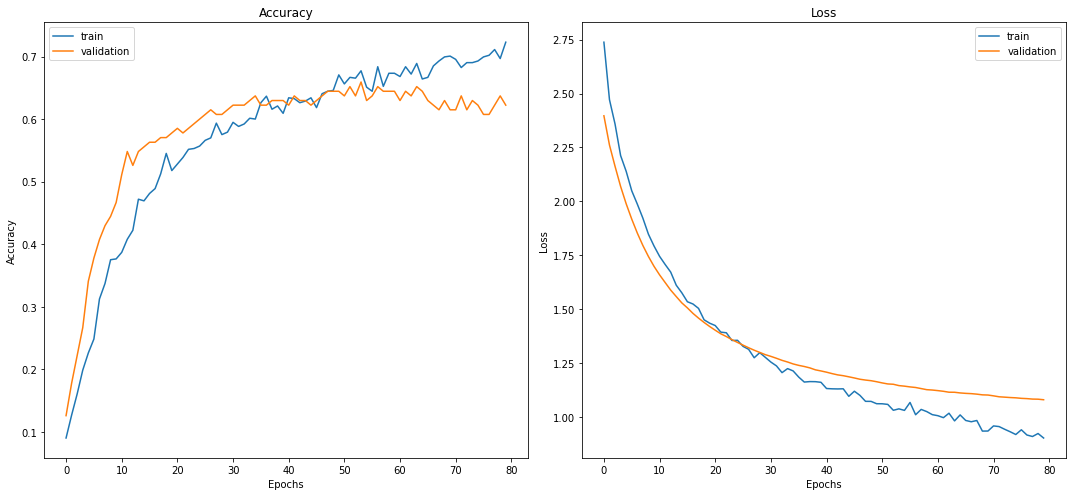

In [52]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##MobileNet Fine-Tuning & Evaluation

In [53]:
MobileNet_inner.trainable = True

MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy']
                        )

print(len(MobileNet_inner.trainable_variables), len(MobileNet_inner.layers))

MobileNet_model.summary()

156 154
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                   

In [54]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = MobileNet_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 80/90
24/24 [==============================] - 10s 172ms/step - loss: 2.1491 - accuracy: 0.3294 - val_loss: 1.5424 - val_accuracy: 0.3852
Epoch 81/90
24/24 [==============================] - 3s 120ms/step - loss: 1.4614 - accuracy: 0.4810 - val_loss: 1.2573 - val_accuracy: 0.5630
Epoch 82/90
24/24 [==============================] - 3s 120ms/step - loss: 1.1659 - accuracy: 0.6118 - val_loss: 1.2310 - val_accuracy: 0.6074
Epoch 83/90
24/24 [==============================] - 3s 119ms/step - loss: 0.9233 - accuracy: 0.6771 - val_loss: 1.2677 - val_accuracy: 0.5556
Epoch 84/90
24/24 [==============================] - 3s 120ms/step - loss: 0.8498 - accuracy: 0.7242 - val_loss: 0.9754 - val_accuracy: 0.6667
Epoch 85/90
24/24 [==============================] - 3s 120ms/step - loss: 0.7078 - accuracy: 0.7582 - val_loss: 0.9784 - val_accuracy: 0.6889
Epoch 86/90
24/24 [==============================] - 3s 119ms/step - loss: 0.5264 - accuracy: 0.8222 - val_loss: 1.0364 - val_accuracy: 0.644

In [55]:
score = MobileNet_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 0.9304153919219971 and val_acc = 0.699999988079071


In [56]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

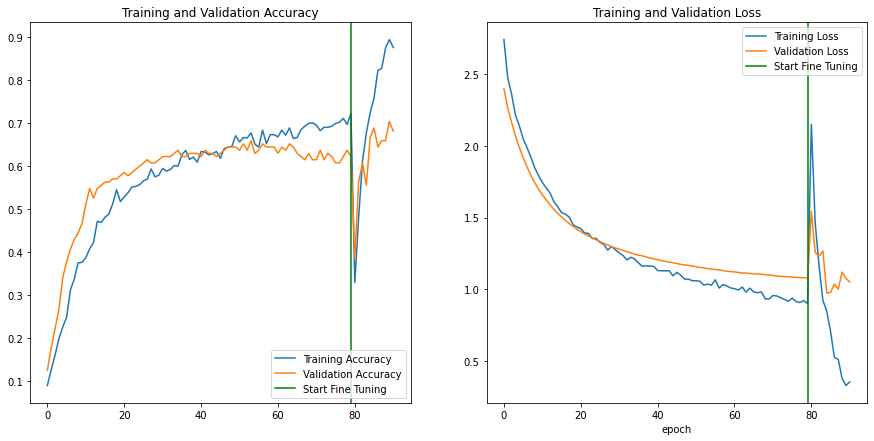

In [57]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [58]:
y_pred_arrs = MobileNet_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

100 <class 'str'>


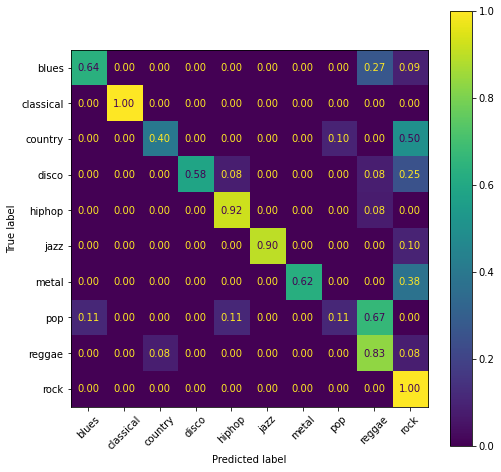

In [59]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

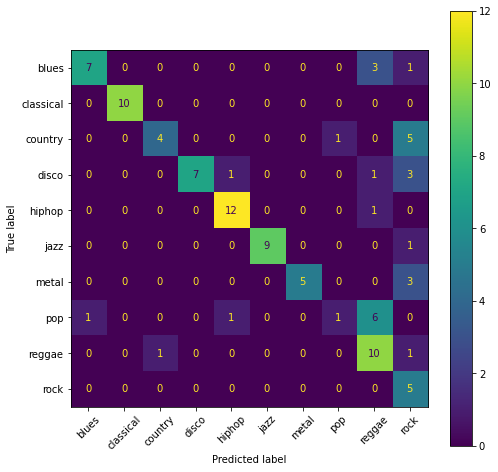

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [61]:
MobileNet_metrics = {
    'MobileNetV2': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
                    np.nan,
                    classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
                    np.nan,
                    np.nan]
                     }

#VGG16:

In [62]:
vgg16_inner = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224, 224, 3)
                                                )

vgg16_inner.trainable = False

print(len(vgg16_inner.trainable_variables), len(vgg16_inner.layers))

58889256/58889256 [==============================] - 0s 0us/step
0 19


In [63]:
inputs = tf.keras.Input(shape=(img_height, img_width, channels))
x = tf.keras.layers.Resizing(224, 224)(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = vgg16_inner(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
VGG16_model = Model(inputs, outputs)

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                    )

VGG16_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [64]:
earlyStopper = EarlyStopping(monitor='val_loss',
                             patience=7,
                             min_delta=0.001,
                             restore_best_weights=True)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.001,
    cooldown=2,
    min_lr=5e-6, )

hist = VGG16_model.fit(tr_ds, validation_data=val_ds, epochs=15, callbacks=[reduceLROnPlat, earlyStopper])

Epoch 1/15
24/24 [==============================] - 10s 269ms/step - loss: 33.0385 - accuracy: 0.1634 - val_loss: 26.0895 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 2/15
24/24 [==============================] - 2s 93ms/step - loss: 24.6248 - accuracy: 0.3477 - val_loss: 21.6402 - val_accuracy: 0.4074 - lr: 1.0000e-04
Epoch 3/15
24/24 [==============================] - 2s 93ms/step - loss: 20.6422 - accuracy: 0.4235 - val_loss: 18.8316 - val_accuracy: 0.4667 - lr: 1.0000e-04
Epoch 4/15
24/24 [==============================] - 2s 93ms/step - loss: 17.9916 - accuracy: 0.4928 - val_loss: 17.0730 - val_accuracy: 0.5185 - lr: 1.0000e-04
Epoch 5/15
24/24 [==============================] - 2s 92ms/step - loss: 16.4152 - accuracy: 0.5778 - val_loss: 15.9479 - val_accuracy: 0.5556 - lr: 1.0000e-04
Epoch 6/15
24/24 [==============================] - 2s 93ms/step - loss: 15.4221 - accuracy: 0.6157 - val_loss: 15.3271 - val_accuracy: 0.5259 - lr: 1.0000e-04
Epoch 7/15
24/24 [====================

In [65]:
score = VGG16_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 12.50439167022705 and val_acc = 0.6499999761581421


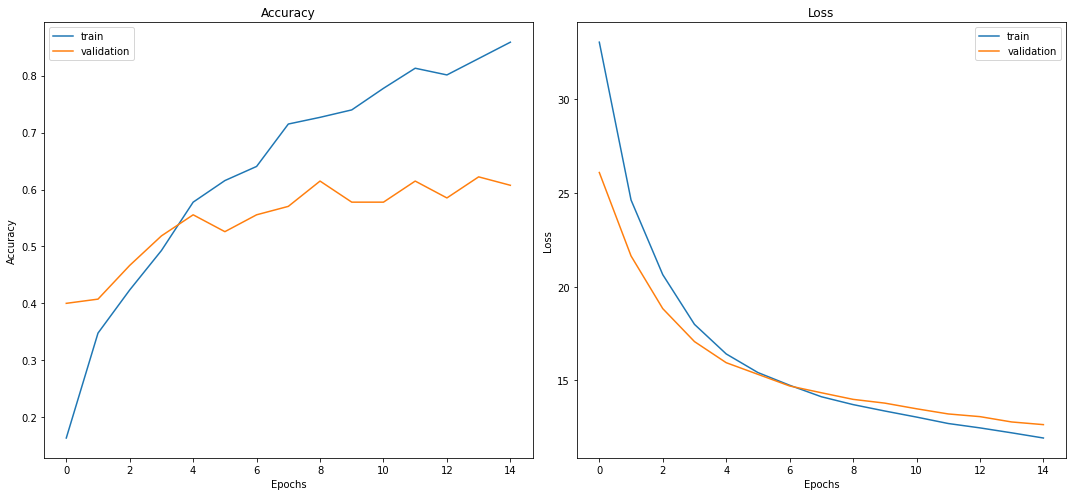

In [66]:
plt.figure(figsize=(15,7))

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##VGG16 Fine-Tuning & Evaluation

In [67]:
vgg16_inner.trainable = True

VGG16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy']
                    )

print(len(vgg16_inner.trainable_variables), len(vgg16_inner.layers))

VGG16_model.summary()

26 19
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)           

In [68]:
initial_epochs = len(hist.epoch)
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

hist_fine = VGG16_model.fit(tr_ds, validation_data = val_ds, epochs=total_epochs, initial_epoch=hist.epoch[-1])

Epoch 15/25
24/24 [==============================] - 9s 283ms/step - loss: 13.3892 - accuracy: 0.1948 - val_loss: 12.2966 - val_accuracy: 0.2667
Epoch 16/25
24/24 [==============================] - 5s 229ms/step - loss: 11.8075 - accuracy: 0.2732 - val_loss: 11.1723 - val_accuracy: 0.3630
Epoch 17/25
24/24 [==============================] - 5s 229ms/step - loss: 10.9072 - accuracy: 0.3974 - val_loss: 10.5815 - val_accuracy: 0.3778
Epoch 18/25
24/24 [==============================] - 5s 229ms/step - loss: 10.3178 - accuracy: 0.4444 - val_loss: 10.1828 - val_accuracy: 0.3481
Epoch 19/25
24/24 [==============================] - 5s 228ms/step - loss: 9.8266 - accuracy: 0.5150 - val_loss: 9.9189 - val_accuracy: 0.4296
Epoch 20/25
24/24 [==============================] - 6s 229ms/step - loss: 9.4765 - accuracy: 0.5098 - val_loss: 9.6888 - val_accuracy: 0.4000
Epoch 21/25
24/24 [==============================] - 5s 229ms/step - loss: 9.1838 - accuracy: 0.5255 - val_loss: 8.9970 - val_accuracy

In [69]:
score = VGG16_model.evaluate(test_ds, verbose=0)
print("val_loss = {} and val_acc = {}".format(score[0], score[1]))

val_loss = 8.022727012634277 and val_acc = 0.6299999952316284


In [70]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

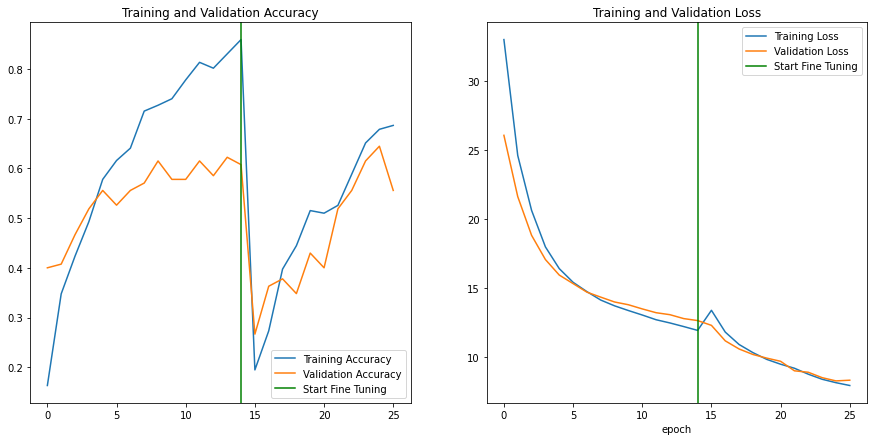

In [71]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(initial_epochs-1, color='g', label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [72]:
y_pred_arrs = VGG16_model.predict(test_ds, verbose=0)

y_pred = []

for i in range(len(y_pred_arrs)):
  y_pred.append(np.argmax(y_pred_arrs[i]))

y_pred_str = [genre_dict[i] for i in y_pred]

print(len(y_pred_str), type(y_pred_str[0]))

100 <class 'str'>


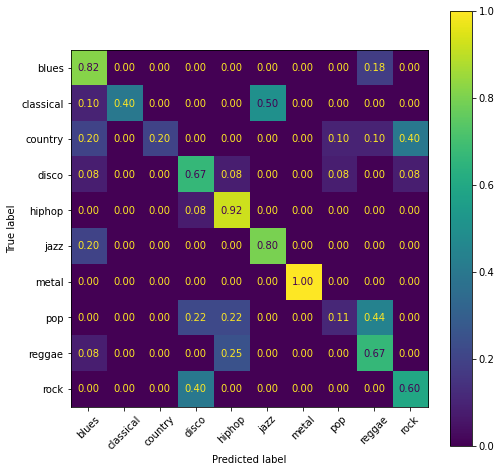

In [73]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               normalize='true',
                                               values_format='.2f',
                                               xticks_rotation=45,
                                               ax=ax)

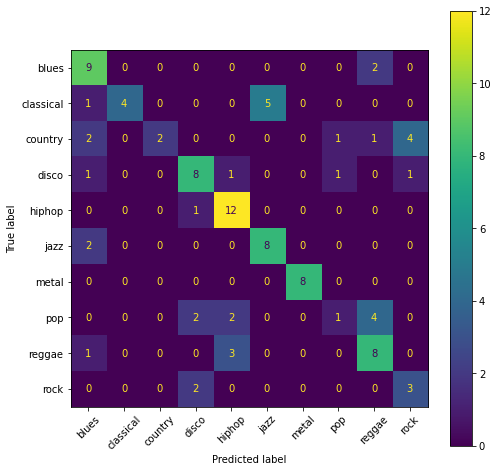

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay.from_predictions(y_true_str,
                                               y_pred_str,
                                               display_labels=class_names,
                                               xticks_rotation=45,
                                               ax=ax)

In [75]:
VGG16_metrics = {
    'VGG16': [classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['accuracy'],
              np.nan,
              classification_report(y_true_str, y_pred_str, labels=class_names, output_dict=True)['macro avg']['f1-score'],
              np.nan,
              np.nan]
              }

#Metrics Summarized

In [76]:
# Metrics compiled / summarized for ALL models
mets_list = [customCNN_metrics, ResNet_metrics, MobileNet_metrics, VGG16_metrics]

new_mets={}

for i in mets_list:
  new_mets.update(i)

In [77]:
new_mets_df = pd.DataFrame.from_dict(new_mets, orient='index', columns = classical_ML_mets.columns)

all_metrics_df = pd.concat([classical_ML_mets, new_mets_df])

all_metrics_df

,accuracy,cv best f1,test macro avg f1,Train AUC,Test AUC
KNearestNeighbors,0.615,0.603849,0.608323,0.965472,0.912458
LogisticRegression,0.700,0.685577,0.691909,0.979939,0.949750
SVM,0.705,0.710727,0.698152,0.999988,0.956889
XGBoost,0.725,0.686891,0.719013,1.000000,0.951889
GradientBoostingClassifier,0.700,0.687605,0.690294,1.000000,0.951528
Custom_CNN,0.670,NaN,0.659566,NaN,NaN
ResNet50,0.620,NaN,0.604377,NaN,NaN
MobileNetV2,0.700,NaN,0.681705,NaN,NaN
VGG16,0.630,NaN,0.590207,NaN,NaN


In [78]:
all_metrics_df = all_metrics_df.drop(columns=['cv best f1', 'Train AUC', 'Test AUC'])
all_metrics_df = all_metrics_df.sort_values('accuracy', ascending=False)
all_metrics_df.to_csv('/content/drive/MyDrive/Springboard/All_Metrics.csv', index_label='Model')

In [79]:
check = pd.read_csv('/content/drive/MyDrive/Springboard/All_Metrics.csv', index_col=0)

check

,accuracy,test macro avg f1
Model,,
XGBoost,0.725,0.719013
SVM,0.705,0.698152
LogisticRegression,0.700,0.691909
GradientBoostingClassifier,0.700,0.690294
MobileNetV2,0.700,0.681705
Custom_CNN,0.670,0.659566
VGG16,0.630,0.590207
ResNet50,0.620,0.604377
KNearestNeighbors,0.615,0.608323
